## Downloading necessary packages and libraries

In [ ]:
pip install fasttext

In [ ]:
pip install torch torchvision torchaudio

In [ ]:
pip install sentencepiece

In [ ]:
pip install sentence-transformers

In [ ]:
pip uninstall keras

In [ ]:
pip install tf-keras

In [1]:
import pandas as pd
import ast
import fasttext
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from rank_bm25 import BM25Okapi
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import mean_squared_error
import numpy as np
import json
from tqdm import tqdm

2024-11-30 18:04:43.601458: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


##  Loading the dataset

In [3]:
reviews_df = pd.read_csv('reviews.csv')
offerings_df = pd.read_csv('offerings.csv')

In [5]:
required_aspects = {'service', 'cleanliness', 'overall', 'value', 'location', 'sleep_quality', 'rooms'}

reviews_df = reviews_df[
    reviews_df['ratings'].apply(
        lambda rating_dict: (
            isinstance((ratings := ast.literal_eval(rating_dict)), dict) and 
            set(ratings.keys()) == required_aspects) )
]

In [7]:
data = pd.merge(reviews_df, offerings_df, left_on='offering_id', right_on='id', how='inner')
display(data)

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id_x,via_mobile,hotel_class,region_id,url,phone,details,address,type,id_y,name
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,2012-12-17,147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,2012-12-17,147639004,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",December 2012,1762573,0,2012-12-18,147697954,False,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '485 5th Av...",hotel,1762573,Andaz 5th Avenue
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",August 2012,1762573,0,2012-12-17,147625723,False,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '485 5th Av...",hotel,1762573,Andaz 5th Avenue
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",December 2012,1762573,0,2012-12-17,147612823,False,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '485 5th Av...",hotel,1762573,Andaz 5th Avenue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436351,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...","“Perfekte Location, modernes & chices Ambiente...","Das Hotel Palomar gehoert zur Kimpton Gruppe, ...","{'username': 'berlinrocks', 'num_cities': 3, '...",July 2010,84093,0,2010-08-02,73467940,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel"
436352,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Superhotel Superlage”,Anlässlich einer Geschäftsreise waren wir das ...,"{'username': 'stellatux', 'num_reviews': 3, 'n...",September 2009,84093,0,2010-08-02,73351022,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel"
436353,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“das etwas andere Hotel”,"Das Hotel liegt in Arlington, eine etwas gehob...","{'username': 'Putzi123', 'num_reviews': 2, 'nu...",December 2009,84093,0,2010-07-01,69298378,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel"
436354,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“RIEN DE MIEUX”,Mon mari et moi sommes restés à l'hôtel du jeu...,"{'username': 'DodieLachine', 'num_reviews': 2,...",June 2010,84093,0,2010-06-29,69142709,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel"


In [9]:
lang_detect_model = fasttext.load_model('lid.176.bin')  

data['language'] = data['text'].apply(
    lambda text: lang_detect_model.predict(text.replace('\n', ' '))[0][0])

In [11]:
print(data['language'].unique())

['__label__en' '__label__es' '__label__it' '__label__de' '__label__fr'
 '__label__pt' '__label__ja' '__label__no' '__label__nl' '__label__sv'
 '__label__ru' '__label__zh' '__label__da' '__label__tr' '__label__el'
 '__label__pl' '__label__ko' '__label__sh' '__label__ar' '__label__ca'
 '__label__id' '__label__th' '__label__hu' '__label__fa' '__label__nn']


### Plot to vizualize the proportion of English reviews

In [13]:
english_reviews_count = data[data['language'] == '__label__en'].shape[0]
other_reviews_count = data[data['language'] != '__label__en'].shape[0]

language_data = pd.DataFrame({
    'Language': ['English', 'Other Languages'],
    'Number of Reviews': [english_reviews_count, other_reviews_count]
})

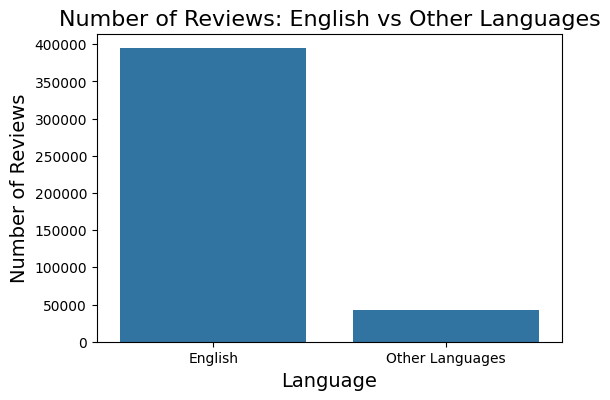

In [15]:
plt.figure(figsize=(6, 4)) 
sns.barplot(x='Language', y='Number of Reviews', data=language_data)
plt.title('Number of Reviews: English vs Other Languages', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.show()

In [17]:
data_english= data[data['language'] == '__label__en']

print(f"Total number of reviews : {len(data)}")
print(f"Remaining english reviews : {len(data_english)}")

Total number of reviews : 436356
Remaining english reviews : 394372


## Preprocessing data

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/stella/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stella/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/stella/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/stella/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [21]:
data_english = data_english.copy()

# Drop useless columns
useless_columns = ['language', 'author', 'date_stayed', 'num_helpful_votes', 'date', 'id_x', 'via_mobile', 'region_id', 'url', 'phone',	'details', 'type', 'id_y', 'address']
data_english = data_english.drop(columns=useless_columns)
display(data_english)

,ratings,title,text,offering_id,hotel_class,name
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,93338,3.0,Hotel Beacon
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",93338,3.0,Hotel Beacon
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,1762573,4.0,Andaz 5th Avenue
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,1762573,4.0,Andaz 5th Avenue
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,1762573,4.0,Andaz 5th Avenue
...,...,...,...,...,...,...
436284,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“One of the best hotels we've stayed in - they...,We stayed four nights at the Hotel Palomar in ...,84093,4.0,"Palomar Washington DC, a Kimpton Hotel"
436285,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“One of my greatest hotel experiences”,"The Palomar Hotel in Washington, DC is just of...",84093,4.0,"Palomar Washington DC, a Kimpton Hotel"
436286,"{'service': 5.0, 'cleanliness': 4.0, 'overall'...",“I love Kimpton hotels!”,"When planning my visit to DC, I knew I would s...",84093,4.0,"Palomar Washington DC, a Kimpton Hotel"
436287,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“This Hotel has Bar None the Most Phenomenal C...,I travel quiet often and not once have I ever ...,84093,4.0,"Palomar Washington DC, a Kimpton Hotel"


In [23]:
data_english['combined_text'] = data_english['title'] + " " + data_english['text']

### Preprocessing for BM25

In [25]:
data_english['cleaned_text'] = data_english['combined_text'].apply(lambda x: re.sub(r'<.*?>', '', x) if isinstance(x, str) else '') 
data_english['cleaned_text'] = data_english['cleaned_text'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))  
data_english['cleaned_text'] = data_english['cleaned_text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))  
data_english['cleaned_text'] = data_english['cleaned_text'].str.lower()  

In [27]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [29]:
data_english['tokens'] = data_english['cleaned_text'].apply(
    lambda x: [lemmatizer.lemmatize(word) for word in word_tokenize(x) if word not in stop_words])

In [31]:
display(data_english[['combined_text', 'cleaned_text', 'tokens']])
data_english = data_english.drop(columns=['cleaned_text'])

,combined_text,cleaned_text,tokens
0,"“Truly is ""Jewel of the Upper Wets Side""” Stay...",truly is jewel of the upper wets side stayed i...,"[truly, jewel, upper, wet, side, stayed, king,..."
1,“My home away from home!” On every visit to NY...,my home away from home on every visit to nyc t...,"[home, away, home, every, visit, nyc, hotel, b..."
2,“Great Stay” This is a great property in Midto...,great stay this is a great property in midtown...,"[great, stay, great, property, midtown, two, d..."
3,“Modern Convenience” The Andaz is a nice hotel...,modern convenience the andaz is a nice hotel i...,"[modern, convenience, andaz, nice, hotel, cent..."
4,“Its the best of the Andaz Brand in the US.......,its the best of the andaz brand in the us i ha...,"[best, andaz, brand, u, stayed, u, andaz, prop..."
...,...,...,...
436284,“One of the best hotels we've stayed in - they...,one of the best hotels weve stayed in they do...,"[one, best, hotel, weve, stayed, everything, r..."
436285,“One of my greatest hotel experiences” The Pal...,one of my greatest hotel experiences the palom...,"[one, greatest, hotel, experience, palomar, ho..."
436286,“I love Kimpton hotels!” When planning my visi...,i love kimpton hotels when planning my visit t...,"[love, kimpton, hotel, planning, visit, dc, kn..."
436287,“This Hotel has Bar None the Most Phenomenal C...,this hotel has bar none the most phenomenal cu...,"[hotel, bar, none, phenomenal, customer, servi..."


### Preprocessing for SentenceTransformers

In [32]:
data_english['cleaned_text'] = data_english['combined_text'].apply(lambda x: re.sub(r'<.*?>', '', x) if isinstance(x, str) else '')
data_english['cleaned_text'] = data_english['cleaned_text'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))
data_english['cleaned_text'] = data_english['cleaned_text'].apply(lambda x: re.sub(r'[^\w\s.,!?;:]', '', x))
data_english['cleaned_text'] = data_english['cleaned_text'].str.lower()

In [35]:
display(data_english[['combined_text', 'cleaned_text']])
data_english = data_english.drop(columns=['combined_text'])

,combined_text,cleaned_text
0,"“Truly is ""Jewel of the Upper Wets Side""” Stay...",truly is jewel of the upper wets side stayed i...
1,“My home away from home!” On every visit to NY...,"my home away from home! on every visit to nyc,..."
2,“Great Stay” This is a great property in Midto...,great stay this is a great property in midtown...
3,“Modern Convenience” The Andaz is a nice hotel...,modern convenience the andaz is a nice hotel i...
4,“Its the best of the Andaz Brand in the US.......,its the best of the andaz brand in the us.... ...
...,...,...
436284,“One of the best hotels we've stayed in - they...,one of the best hotels weve stayed in they do...
436285,“One of my greatest hotel experiences” The Pal...,one of my greatest hotel experiences the palom...
436286,“I love Kimpton hotels!” When planning my visi...,i love kimpton hotels! when planning my visit ...
436287,“This Hotel has Bar None the Most Phenomenal C...,this hotel has bar none the most phenomenal cu...


### Grouping per "offering_id"

In [37]:
grouped = data_english.groupby('offering_id').agg( 
    tokens=('tokens', lambda x: x.tolist()), 
    cleaned_text=('cleaned_text', lambda x: ' '.join(x))).reset_index()

In [39]:
grouped['tokens_combined'] = grouped['tokens'].apply(lambda x: [token for sublist in x for token in sublist])
grouped = grouped.drop(columns = ['tokens'])

In [41]:
display(grouped)

,offering_id,cleaned_text,tokens_combined
0,72572,will go back i had to make fast visit to seatt...,"[go, back, make, fast, visit, seattle, found, ..."
1,72579,breakfast in the morning is a huge savings! gr...,"[breakfast, morning, huge, saving, great, serv..."
2,72586,great place to stay beautiful views of the spa...,"[great, place, stay, beautiful, view, space, n..."
3,72598,will not stay here or recommend this hotel thi...,"[stay, recommend, hotel, hotel, need, serious,..."
4,73236,my nephews graduation my experience at this da...,"[nephew, graduation, experience, day, inn, per..."
...,...,...,...
3722,3513445,best economy hotel near phoenix airport new ro...,"[best, economy, hotel, near, phoenix, airport,..."
3723,3523356,a fourstar hotel at a twostar price....worth t...,"[fourstar, hotel, twostar, priceworth, money, ..."
3724,3541823,fantastic location good value inn staff absol...,"[fantastic, location, good, value, inn, staff,..."
3725,3572384,"dont bother crowded, noisy, dirty. service is ...","[dont, bother, crowded, noisy, dirty, service,..."


## 1st model : Implementing BM25

In [43]:
hotel_tokens_dict = dict(zip(grouped['offering_id'], grouped['tokens_combined']))
tokenized_corpus = grouped['tokens_combined'].tolist()
bm25 = BM25Okapi(tokenized_corpus)

In [45]:
def recommend_hotel_bm25(hotel_id_query):

    tokens_query = hotel_tokens_dict.get(hotel_id_query, [])
    scores = bm25.get_scores(tokens_query)
    
    for i, score in enumerate(scores):
        if grouped.iloc[i]['offering_id'] == hotel_id_query:
            scores[i] = -1
            
    best_index = np.argmax(scores)
    recommended_hotel_id = grouped.iloc[best_index]['offering_id']
    
    return recommended_hotel_id

In [47]:
#test
import time

start_time = time.time()
recommended_hotel = recommend_hotel_bm25(87617)
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time : {execution_time:.4f} secondes")
print(f"Recommanded hotel : {recommended_hotel}")


Execution time : 162.8143 secondes
Recommanded hotel : 114581


## 2nd part : Beating BM25 by hybriding it with SentenceTransformers

In [49]:
model_st = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model_st.encode(grouped['cleaned_text'].tolist(), convert_to_tensor=True)

In [51]:
def recommend_hotel_hybrid(hotel_id_query, alpha):

    tokens_query = hotel_tokens_dict.get(hotel_id_query, [])
    bm25_scores = bm25.get_scores(tokens_query)
    
    for i, score in enumerate(bm25_scores):
        if grouped.iloc[i]['offering_id'] == hotel_id_query:
            bm25_scores[i] = -1
    
    # cosinus similarity computing
    hotel_query = grouped[grouped['offering_id'] == hotel_id_query].iloc[0]
    query_embedding = model_st.encode(hotel_query['cleaned_text'], convert_to_tensor=True)
    cos_similarities = util.pytorch_cos_sim(query_embedding, embeddings)[0].cpu().numpy()
    cos_similarities[grouped['offering_id'] == hotel_id_query] = -1
    
    # normalization
    bm25_scores_normalized = (bm25_scores - np.min(bm25_scores)) / (np.max(bm25_scores) - np.min(bm25_scores))
    cos_similarities_normalized = (cos_similarities - np.min(cos_similarities)) / (np.max(cos_similarities) - np.min(cos_similarities))
     # combination of the scores with alpha weight
    bm25_weight = alpha
    sbert_weight = 1 - alpha
    combined_scores = bm25_weight * bm25_scores_normalized + sbert_weight * cos_similarities_normalized
    
    best_index = np.argmax(combined_scores)
    recommended_hotel_id = grouped.iloc[best_index]['offering_id']
    
    return recommended_hotel_id


In [55]:
#test
import time

start_time = time.time()
recommended_hotel = recommend_hotel_hybrid(87617, 0.5)
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time : {execution_time:.4f} secondes")
print(f"Recommanded hotel : {recommended_hotel}")


Execution time : 171.0286 secondes
Recommanded hotel : 609738


## Evaluation by computing ratings' MSE

### Calculate average scoring on each aspect for each hotel

In [61]:
data_english['ratings'] = data_english['ratings'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else None if isinstance(x, str) and json.JSONDecodeError else x
)

In [63]:
ratings_mean = data_english.groupby('offering_id')['ratings'].apply(lambda x: {
    k: sum(d[k] for d in x) / len(x) for k in x.iloc[0].keys()}).reset_index()

In [65]:
display(ratings_mean)

,offering_id,level_1,ratings
0,72572,service,4.604061
1,72572,cleanliness,4.634518
2,72572,overall,4.390863
3,72572,value,4.324873
4,72572,location,4.568528
...,...,...,...
26084,3574675,overall,2.750000
26085,3574675,value,3.000000
26086,3574675,location,3.500000
26087,3574675,sleep_quality,3.000000


In [67]:
ratings_df = ratings_mean.pivot(index='offering_id', columns='level_1', values='ratings')
display(ratings_df)

level_1,cleanliness,location,overall,rooms,service,sleep_quality,value
offering_id,,,,,,,
72572,4.634518,4.568528,4.390863,4.284264,4.604061,4.329949,4.324873
72579,4.264463,4.206612,3.892562,3.876033,4.247934,3.776860,4.148760
72586,4.301587,4.587302,4.071429,4.015873,4.261905,4.119048,4.087302
72598,3.243243,3.027027,2.918919,3.189189,3.243243,3.270270,3.054054
73236,3.111111,4.111111,3.388889,3.222222,4.277778,3.722222,3.777778
...,...,...,...,...,...,...,...
3513445,4.000000,3.000000,3.666667,3.666667,3.666667,4.000000,4.000000
3523356,4.928571,4.500000,4.571429,4.500000,4.928571,4.571429,4.214286
3541823,4.500000,5.000000,4.000000,3.250000,4.750000,3.750000,4.500000


In [69]:
def calculate_aspect_mse(hotel_id_query, recommended_hotel_id):
    
    query_ratings = ratings_df.loc[hotel_id_query]
    recommended_ratings = ratings_df.loc[recommended_hotel_id]
    
    mse_per_aspect = {
        aspect: (query_ratings[aspect] - recommended_ratings[aspect]) ** 2
        for aspect in ratings_df.columns
    }
    
    average_mse = sum(mse_per_aspect.values()) / len(mse_per_aspect)
    
    return mse_per_aspect, average_mse

### Testing on a random sample

In [79]:
sampled_hotel_ids = random.sample(grouped['offering_id'].tolist(), 5)

In [81]:
from tqdm import tqdm
import random

alpha_values = np.linspace(0, 1, 11)  
results = []

best_mse = float('inf')  # Start with a very large value
best_alpha = None

# progression bar
for alpha in tqdm(alpha_values, desc="Alpha Progression"):
    mse_scores = []
    
    # MSE for each hotel
    for hotel_id_query in tqdm(sampled_hotel_ids, desc=f"Processing alpha={alpha:.2f}", leave=False):
        recommended_hotel = recommend_hotel_hybrid(hotel_id_query=hotel_id_query, alpha=alpha)
        # MSE between query and recommendation
        mse_per_aspect, average_mse = calculate_aspect_mse(hotel_id_query, recommended_hotel)
        mse_scores.append(average_mse)
    
    # average MSE
    average_mse_alpha = np.mean(mse_scores)
    results.append((alpha, average_mse_alpha))
    print(f"Alpha: {alpha:.2f}, Average MSE: {average_mse_alpha:.4f}")

if average_mse_alpha < best_mse: # check for best alpha
        best_mse = average_mse_alpha
        best_alpha = alpha

results_df = pd.DataFrame(results, columns=["alpha", "average_mse"])


Alpha Progression:   9%|██▎                      | 1/11 [01:02<10:27, 62.73s/it]

Alpha: 0.00, Average MSE: 0.3432



Alpha Progression:  18%|████▌                    | 2/11 [02:01<09:01, 60.15s/it]

Alpha: 0.10, Average MSE: 1.1636



Alpha Progression:  27%|██████▊                  | 3/11 [03:04<08:12, 61.53s/it]

Alpha: 0.20, Average MSE: 1.1442



Alpha Progression:  36%|█████████                | 4/11 [04:02<07:02, 60.29s/it]

Alpha: 0.30, Average MSE: 1.1284



Alpha Progression:  45%|███████████▎             | 5/11 [05:07<06:12, 62.09s/it]

Alpha: 0.40, Average MSE: 1.1284



Alpha Progression:  55%|█████████████▋           | 6/11 [06:10<05:11, 62.26s/it]

Alpha: 0.50, Average MSE: 1.1284



Alpha Progression:  64%|███████████████▉         | 7/11 [07:22<04:21, 65.28s/it]

Alpha: 0.60, Average MSE: 0.8868



Alpha Progression:  73%|██████████████████▏      | 8/11 [08:28<03:17, 65.71s/it]

Alpha: 0.70, Average MSE: 0.3018



Alpha Progression:  82%|████████████████████▍    | 9/11 [09:25<02:05, 62.93s/it]

Alpha: 0.80, Average MSE: 0.2824



Alpha Progression:  91%|█████████████████████▊  | 10/11 [10:20<01:00, 60.61s/it]

Alpha: 0.90, Average MSE: 0.2824



Alpha Progression: 100%|████████████████████████| 11/11 [11:23<00:00, 62.12s/it]

Alpha: 1.00, Average MSE: 0.2959


## Hotel recommendation app: 

In [83]:
try:
    query_hotel_id = int(input("Enter your hotel ID to find the most similar one : "))
except ValueError:
    print("Error : please enter an integer")
    exit()

if query_hotel_id not in grouped['offering_id'].values:
    print(f"Error : ID {query_hotel_id} doesn't exist in database")
    exit()

recommended_hotel = recommend_hotel_hybrid(query_hotel_id, best_alpha)

print(f"Recommended hotel ID: {recommended_hotel}")

Enter your hotel ID to find the most similar one :  87617


Recommended hotel ID: 114581


In [89]:
hotel_query_info = data_english.loc[data_english['offering_id'] == query_hotel_id].iloc[0]
hotel_recommended_info = data_english.loc[data_english['offering_id'] == recommended_hotel].iloc[0]

data_hotel = {
    'Hotel query': [
        query_hotel_id,
        hotel_query_info['name'],
        hotel_query_info['hotel_class']
    ],
    'Recommendation': [
        recommended_hotel,
        hotel_recommended_info['name'],
        hotel_recommended_info['hotel_class']
    ]
}

df_hotel_info = pd.DataFrame(data_hotel, index=['Hotel ID','Name','Class'])
display(df_hotel_info)

,Hotel query,Recommendation
Hotel ID,87617,114581
Name,Hyatt Regency Chicago,Swissotel Chicago
Class,4.0,4.0
